In [1]:
from tools.quantum_tools import trotter_circuit, quantum_simulator
from tools.classical_tools import classical_simulator
from tools.noise_tools import get_noise_model
from plotting import compare_errors_4, compare_histograms, compare_errors_2, compare_errors_our_mit, compare_errors_mit, compare_energies, compare_probabilities, compare_noisy
from numpy import pi, linspace, arange, array, zeros_like, divide
from qiskit import transpile
from qiskit import IBMQ
from qiskit.providers.aer import QasmSimulator

In [2]:
if not IBMQ.active_account():
    if not IBMQ.stored_account():
        with open('Token') as file:
            token = file.readline()

        IBMQ.save_account(token)

    IBMQ.load_account()

name = 'ibm_oslo'
provider = IBMQ.get_provider(hub = 'ibm-q', group = 'open', project = 'main')
device_backend = provider.get_backend(name)

In [3]:
max_time = 2 * pi
frequency = 1

t = linspace(0, max_time, 500) 
qt = linspace(0, max_time, 50) 

shots = 3000
backend = QasmSimulator()

n = 2 # Difference when the number of TLSs is even or odd because the parity is conserved by the Hamiltonian
m = 4 # Different accuracy with a different number of trotter steps
g = 1

parameters = [1.990e-2, 2e-3, 5.910e-3, 161.48e-6, 57.34e-6, 337e-9]

##  Dicke Hamiltonian (dispersive limit) as Quantum Battery
---

 The study of quantum batteries is fundamentally driven by the ambition of realizing devices of atomic and molecular size, which could gain a considerable advantage over their macroscopic counterparts for some particular tasks.
 
### What is a Quantum Battery?

 A **Quantum Battery** (QB) can be defined as a $d$-dimensional quantum systems with non-degenerate energy levels from which work can be reversibly extracted – and on which energy can be reversibly deposited – by means of cyclic unitary operations.


<div>
<img src="./images/TLS.png" width="250"/>
</div>


 More precisely, here we will consider an **array of $n$ Two-Level System** (TLS) coupled with a quantized single-mode electro-magnetic field exploited to charge it up.

<div>
<img src="./images/arrayTLS.png" width="500"/>
</div>

The **Hamiltonian** associated to this kind of model is given by [[1]](#DH2):

$$
\mathcal{H}=\hbar\omega_c a^\dagger a +\omega_zS_z+2\omega_c\lambda_tS_x(a+a^\dagger)
$$

also known as *Dicke Hamiltonian*. Where:
 - $a$, $a^\dagger$ are the **creation and annihilation operator** for the single-mode cavity with frequency $\omega_c$,
 - $
S_i=\frac{\hbar}{2}\sum_{l=1}^n\sigma_i^{(l)}
$ are the components of the **collective spin operators** expressed in terms of Pauli operators $\sigma_i^{(l)}$ of the $l$-th TLS,
 - the **energy splitting** of each 2-level system is given by $\hbar\omega_z$,
 - $λ_t$ is the **coupling strength** between cavity and array.


The above Hamiltonian, in the **dispersive regimes** we are interested in ($\omega_{c} \gg \omega_{z}$), can be reduced to an **effective Hamiltonian** (with $\hbar=1$):

$$\mathcal{H} = \omega_z S_z - g S^2_x=\mathcal{H}_a+\mathcal{H}_b$$

<mark>we will study the evolution described by this effective Hamiltonian.</mark>

## Quantum simulation 
---
We note that the state $|G\rangle>=|1\rangle^{\otimes n}$ corresponds to the fundamental state of the free Hamiltonian $\mathcal{H}_a$ (without coupling) and represents an uncharged QB. We want to observe **how much and how fast it it can be charged** (spin flip) using the evolution of the full Hamiltonian $\mathcal{H}$ (with coupling).

We thus perform the **time evolution** from the  $|\psi\rangle_0=|1\rangle^{\otimes n}$ state implementing a quantum circuit and use it to study the properties of the physical system. 

<div>
<img src="./images/conceptual_qc_simulation.png" width="400"/>
</div>

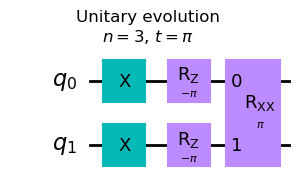

In [18]:
figure = trotter_circuit(n, pi, 1, g).draw('mpl')
figure.suptitle('Unitary evolution\n' + '$n = 3$, $t=\pi$')
display(figure)

Due to the fact that the terms which appear in the Hamiltonian do not commute, we must use the **Trotter-Suzuki time evolution**. It is based on the fact that the following holds [[3]](#TS):


$$
U(t)=e^{-\mathcal(i)\mathcal{H} t}=e^{-\mathcal{i}\sum_k H_k t}=\left(\prod_k e^{-\frac{\mathcal i H_k t}{m}} \right)^m+O\left(\frac{t^2}{m}\right)
$$

where $H_k$ are the **terms which do not commute** with each other in the Hamiltonian and $m$ are the **trotter steps**. It is useful because each factor in the product can be implemented by a quantum gate. Thus, in the computation, many circuits like the one above will be composed one after the other. We have to implement trotterization at each time step of the time discretization.

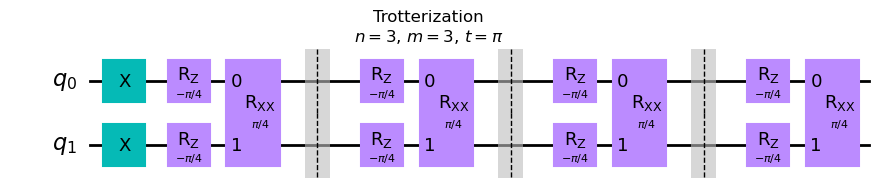

In [19]:
figure = trotter_circuit(n, pi, m, g).draw('mpl')
figure.suptitle('Trotterization\n' +'$n = 3$, $m=3$, $t=\pi$')
display(figure)

### Ideal simulation

First, we perform the time evolution from the ground state, implementing the Trotter-Suzuki time evolution. In this section we implement a **noiseless quantum simulation** and **compare** the results with the one obtained with a **classical simulation**.

We used `QasmSimulator` for the quantum simulation. For the classical simulation we implement everything using `numpy` and performing matrix-matrix multiplications.

We study the following observables:
 - probability of having $|E\rangle=|0\rangle^{\otimes n}$, that is the **probability of observing the battery fully charged**,
 - the **average energy** of the first contribution to the Hamiltoninan (that is the internal energy): $$E_a(t)=\langle \mathcal{H}_a\rangle_{\rho(t)} -\langle \mathcal{H}_a\rangle_{\rho(0)} =\text{tr}[\rho(t)\mathcal{H}_a]-\text{tr}[\rho(0)\mathcal{H}_a]$$ which can be interpreted as the stored energy and, for closed systems, is the simply the opposite of the energy $E_b(t)$ trapped into the interaction [[2]](#QB),
 - the **maximal average power** for the cases $gn > 1$ and $gn < 1$, where $G=gn$ is the effective coupling .

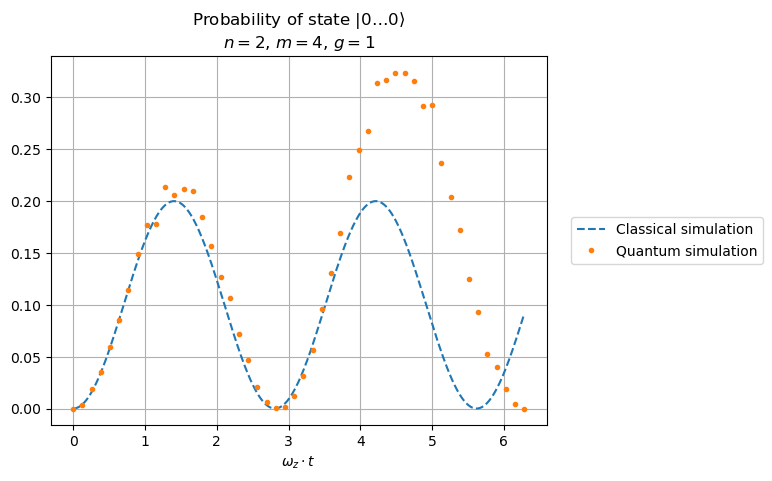

In [5]:
qp, qi_nrg, qc_nrg = quantum_simulator(qt, n, m, g, backend, device_backend, shots)
p, i_nrg, c_nrg = classical_simulator(t, n, g)
compare_probabilities(t, qt, p, qp, n, m, g)

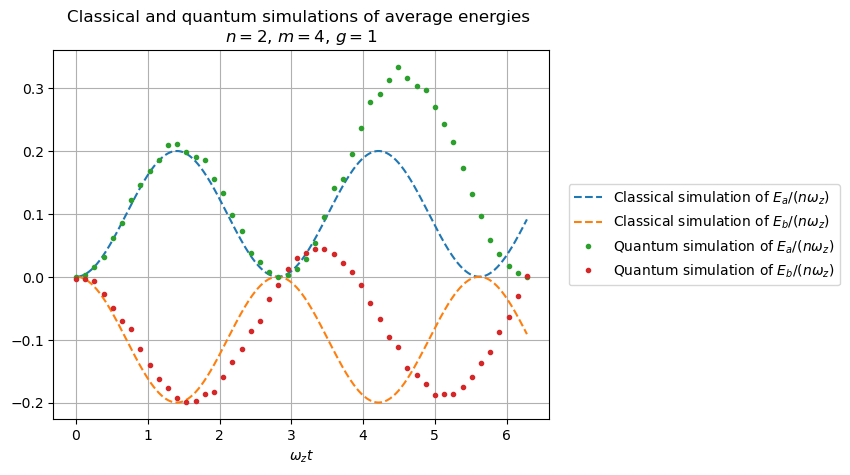

In [21]:
compare_energies(t, qt, i_nrg, qi_nrg, c_nrg, qc_nrg, n, m, g)

As expected, for a given number of trotter steps, the quantum simulation results diverge more with increasing simulation time.
Moreover, for a given time interval, increasing the number of trotter steps provides more accurate results.
However, this affects negatively the accumulation of noise, as we will see later on.

The **average power** of the unitary charging between $\rho(0)$ and $\rho(T)$ is defined as:

$$
\langle P\rangle=\frac{W}{T}
$$

where $W=E_a(T)$ is the energy deposited on the battery during the charging process. 

<Mark>We study the maximal power for different combinations of number of TLs and coupling strength,</Mark> that is to say $n$ and $g$ respectively. Here we used $m=10$ trotter steps.

<div>
<img src="./images/quantum_power.png" width="600"/>
</div>

The boundary between the region where the battery charges effectively for increasing coupling and number of sites and the region with ineffective charge seems to follow an hyperbolic curve.

### Noisy simulation
Here we perform a quantum **simulation introducing a noise model** taylored for the superconducting IBM devices. The simplest model presenting the typical noises of these devices implements [[4]](#PHD):
 - **depolarization and relaxation errors** after the single-qubit and two-qubits gates,
 - a **bit-flip error** before measurement.

The idea is to create a function which takes some noise parameters that we use as inputs to the errors above. These parameters are provided by the real device.

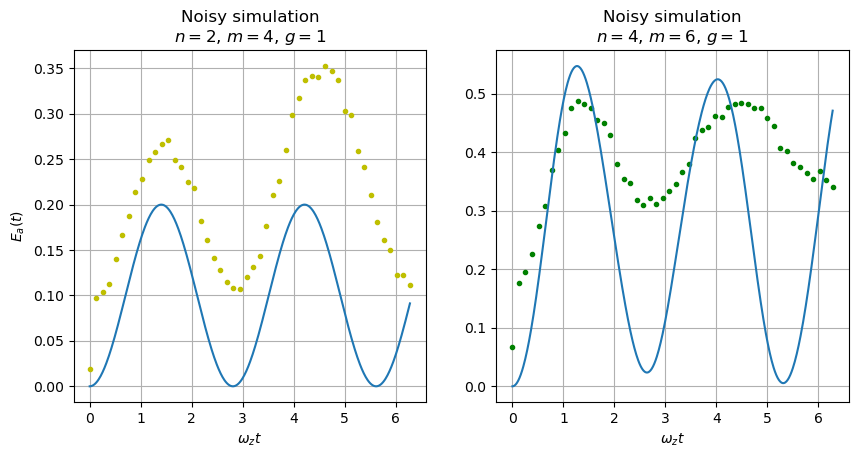

In [22]:
compare_errors_2(t, qt, (n, 4), (m, 6), (g, 1), shots, parameters, device_backend)

<Mark>Now we will introduce progressively one kind of error at the time and try to understand which ones contributes more.</Mark>

n so doing it should be kept in mind that we fixed at the beginning the ground state as $|G\rangle=|1\rangle^{\otimes n}$. This could affect the implementation of the relaxation error since the default configuration at the equilibrium for the qiskit function is the opposite of ours.

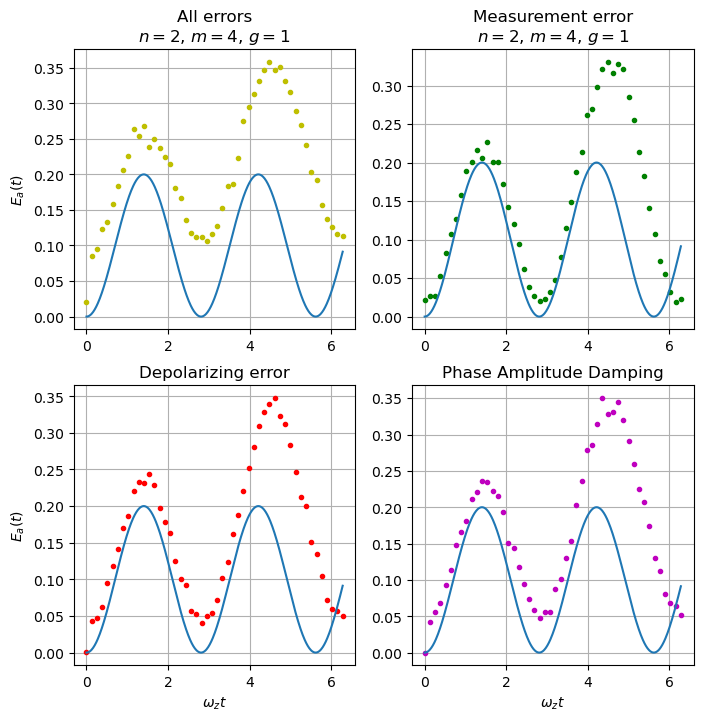

In [6]:
compare_errors_4(t, qt, i_nrg, n, m, g, shots, parameters, device_backend)

Analyzing the contribution of each error type, we see that the smallest contribution is given by the measurement error while <Mark>the depolarizing error and the phase amplitude damping error introduce larger and similar contributions</Mark>. This is line with expectations since the latter types of errors affect the evolution of the computation and their effects are amplified. 

Single qubit error only (4 qubits, 6 trotter steps)    | Double qubit error only (4 qubits, 6 trotter steps)  
:-----------------------------------------------------:|:---------------------------------------------:
<img src="./images/SingleQbit_4_6_1.png" width="500"/> | <img src="./images/DoubleQbit_4_6_1.png" width="500"/>
   
   
In terms of impact of single qubit and double qubit error, we see that the latter has greater importance. In a double qubit gate, the error on one qubit affects the error on the other qubit as well, contrary on what happens in the case of two single qubit gates. This is translated mathematically into a tensor product in the former case and in a composition of errors in the latter case.

### Error mitigation

From these noisy simulations we would like to extract useful information in order to correct the results obtained from a real _quantum computer_.

The first approach that we implemented is the **measurement error mitigation**. In order to perform it, we used the tools provided by `qiskit`. The idea is to build a model of bit-flip errors before the measurement. In order to do it, one can try to run a circuit without any gates starting from each possible initial state. In this way, it is possible to build up a matrix that can be applied to the noisy outcomes to get the mitigated ones.

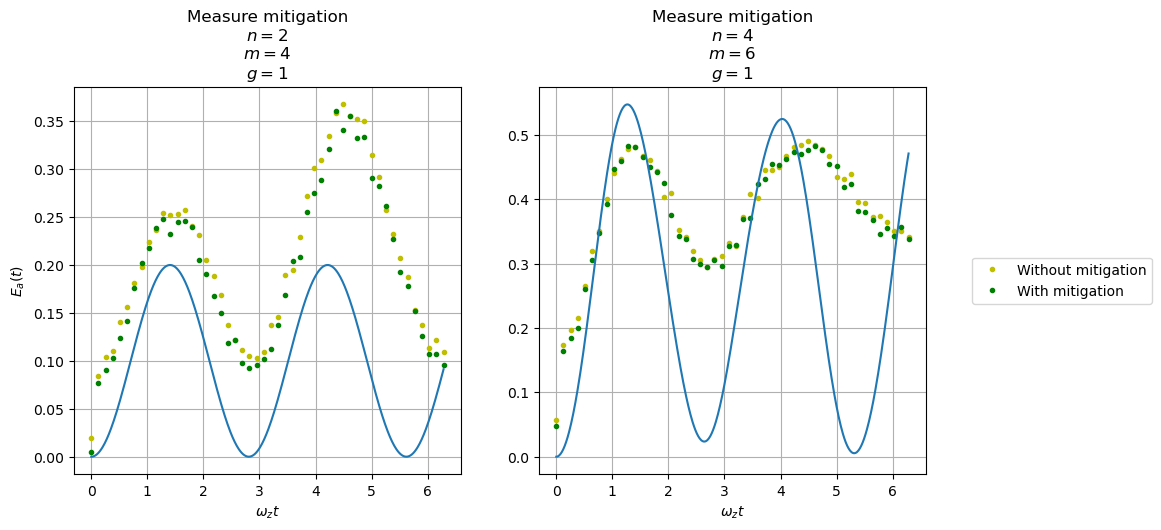

In [24]:
compare_errors_mit(t, qt, (n, 4), (m, 6), (g, 1), shots, parameters, device_backend)

In order to try to improve the error correction, we turn our attention to the physical system. Indeed, we can try to exploit its symmetries. In particular, we notice that the Hamiltonian obeys a specific symmetry with respect to the **spin parity operator** $\hat{\Pi}=e^{-\mathcal{i}\pi \hat{S}_{z}}$:

$$\left[\hat{\mathcal{H}},\hat{\Pi}\right] = 0 $$

thus the parity (that is the eigenvalue of $\hat{\Pi}$) is conserved during the evolution. 
This allows us to discard _a priori_ some physically-forbidden states from the counting results because we know that the only states allowed by the physical system are the ones which have the same parity of the initial state. 

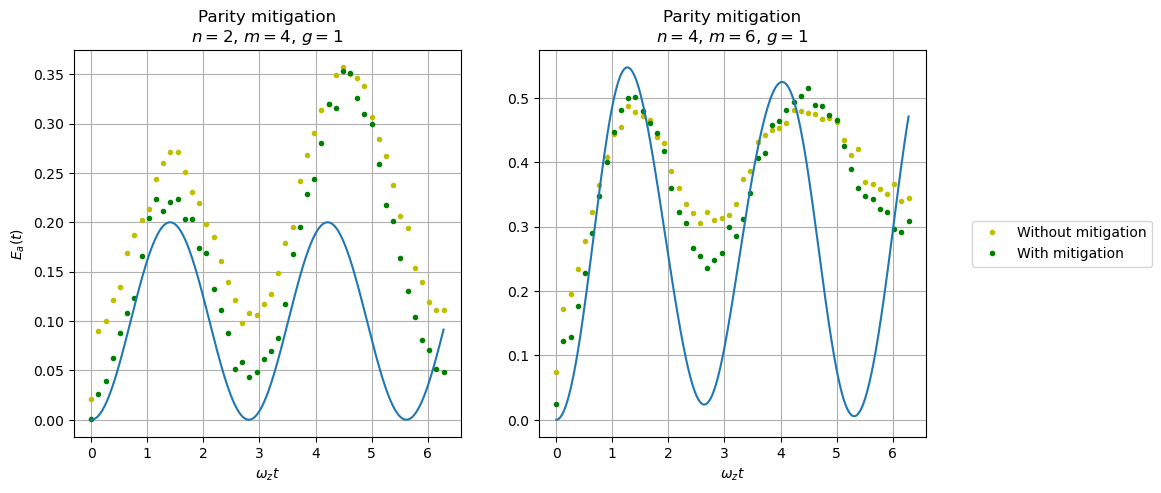

In [25]:
compare_errors_our_mit(t, qt, (n, 4), (m, 6), (g, 1), shots, parameters, device_backend)

However, as you can see the magnitude of this kind of correction worsen as the number of qubits increases. This is probably due to the prevailing non-linear accumulation of noise linked to the non linear scaling of the number of gates in the transpiled circuit as it can be noticed below.

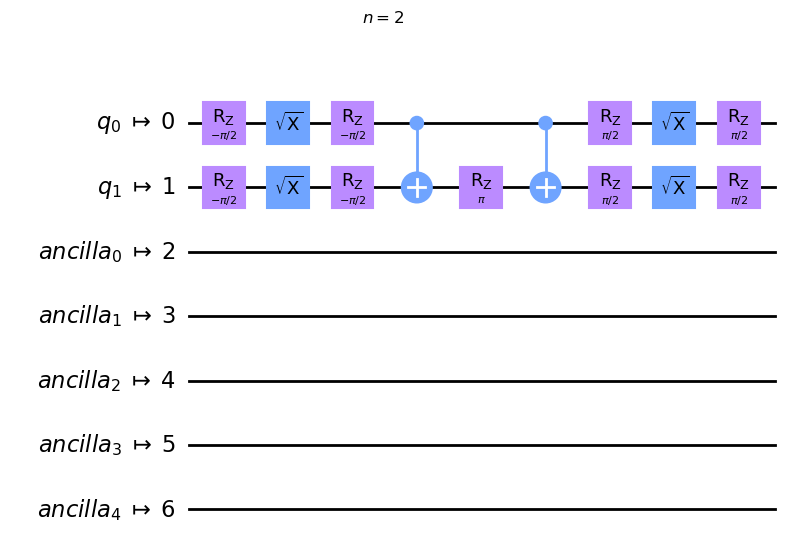

In [26]:
figure = transpile(trotter_circuit(2, pi, 1, g), device_backend).draw('mpl')
figure.suptitle(r'$n = 2$')
display(figure)

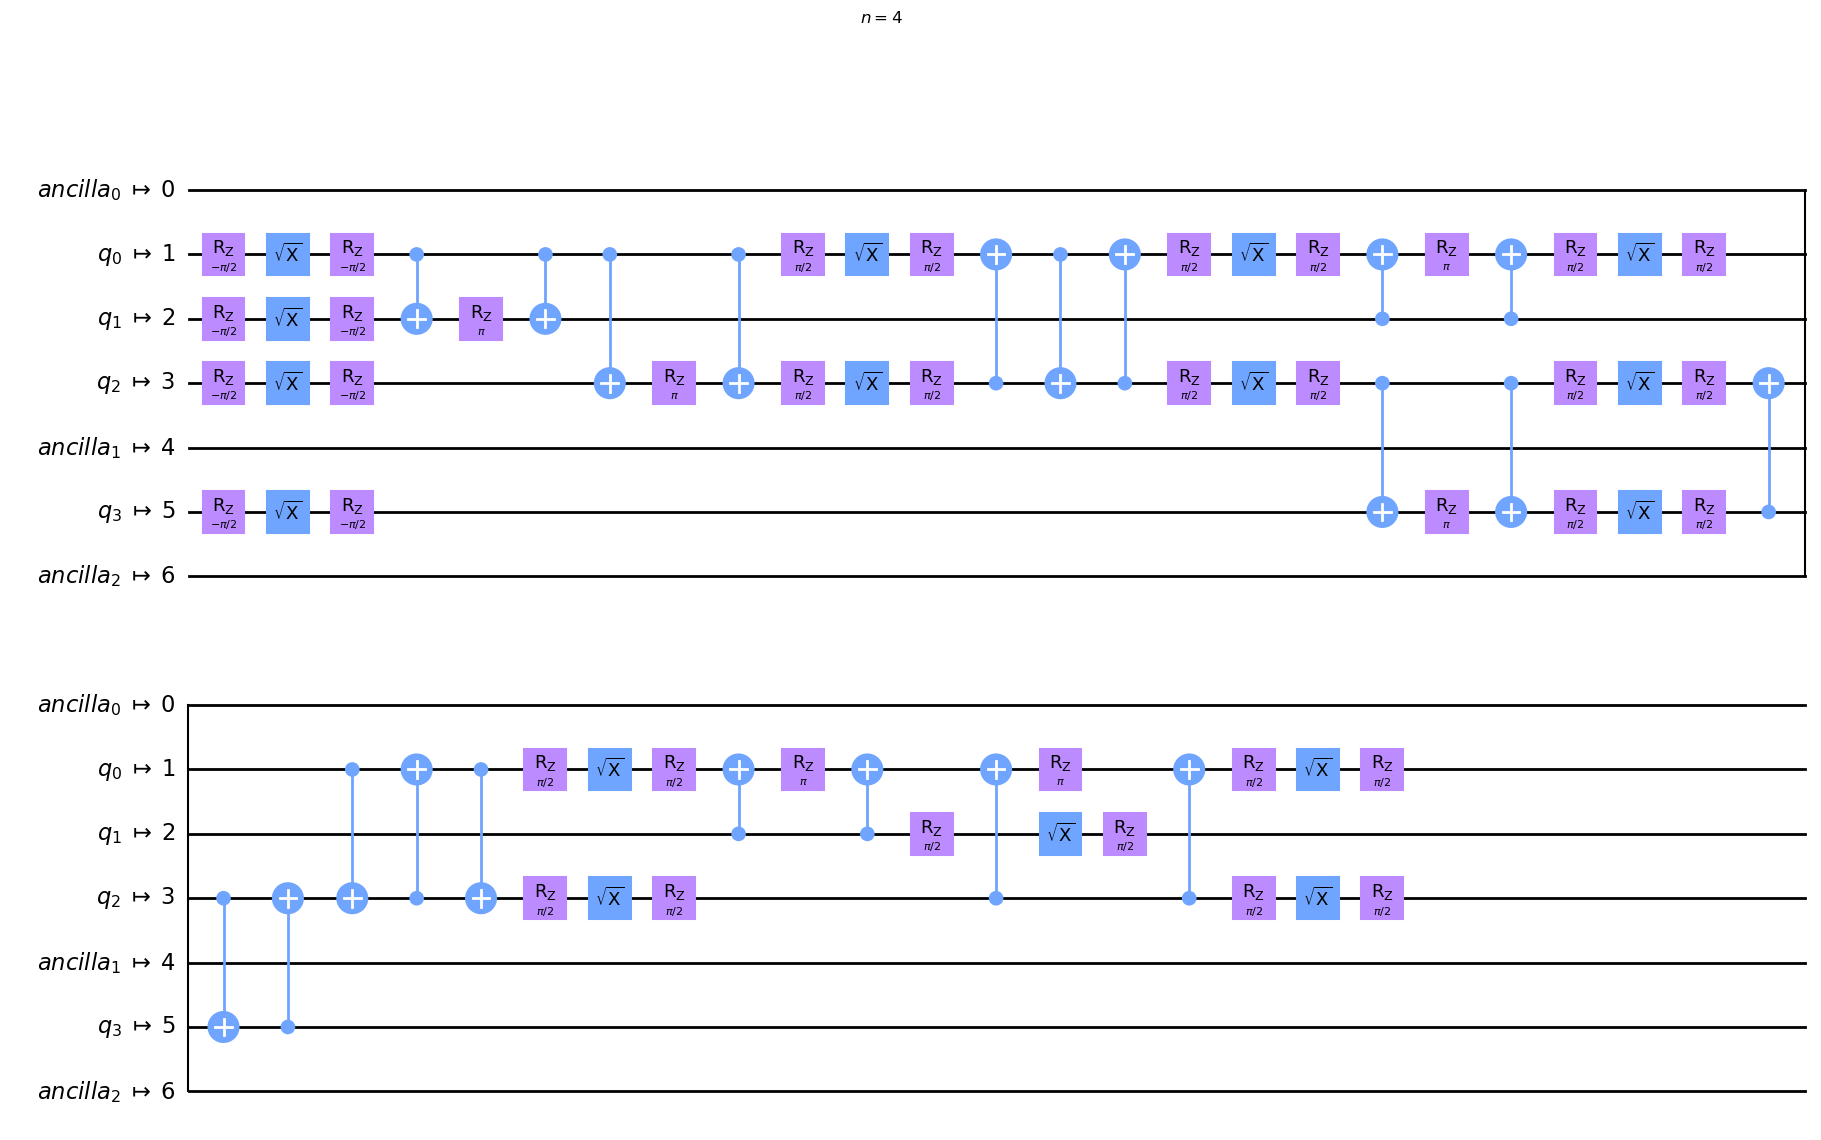

In [27]:
figure = transpile(trotter_circuit(4, pi, 1, g), device_backend).draw('mpl')
figure.suptitle(r'$n = 4$')
display(figure)



Another issue that can influence this trend could be traced back to the negligible amount of the removed counts (associated to the parity-forbidden states) as the number of qbits increases.


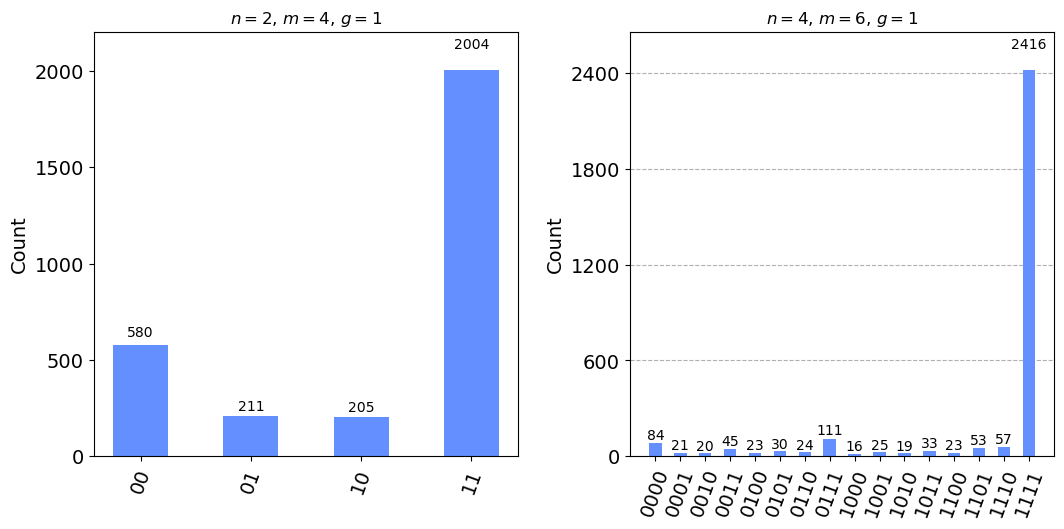

In [28]:
compare_histograms((n, 4), (m, 6), (g, 1), (pi / 2, 2.8), parameters, shots, device_backend)

Growing with system complexity these first techniques are no more effective and one should devise more reliable mitigation models that take into account the single gate behavior: this _de facto_ represent the ultimate frontier of quantum computing. The absence of a reliable mitigation error model prevents from obtaining useful results from the quantum simulations!

### Simulation on real device
The circuit that will run on the real IBM device will present a lot of physical gates and thus a great amount of noise will be introduced during its execution. Indeed, as you can see by the below figure, the simulation is very noisy and we can't extract many information from it. 

In [ ]:
dqp, dqi_nrg, dqc_nrg = quantum_simulator(qt, n, m, frequency, g, device_backend, device_backend, shots)

In [ ]:
compare_probabilities(t, qt, p, dqp, m, n, g)

In [ ]:
compare_energies(t, qt, i_nrg, dqi_nrg, c_nrg, dqc_nrg, m, n, g)

### References

<a id="DH2">[1]</a> 
Juan Román-Roche and David Zueco (2022).
*Effective theory for matter in non-perturbative cavity QED*.
SciPost Phys. Lect.Notes 50.
[10.21468/SciPostPhysLectNotes.50](https://scipost.org/10.21468/SciPostPhysLectNotes.50).

<a id="QB">[2]</a> 
Francesco Campaioli, Felix A. Pollock, and Sai Vinjanampathy (2018).
*Quantum Batteries*. arXiv.
[arXiv:1805.05507](https://doi.org/10.48550/arXiv.1805.05507).

<a id="TS">[3]</a> 
Francesco Tacchino, Alessandro Chiesa, Stefano Carretta and Dario Gerace (2019).
*Quantum Computers as Universal Quantum Simulators: State-of-the-Art and Perspectives*. Advanced Quantum Technologies.
[10.1002%2Fqute.201900052](https://doi.org/10.1002%2Fqute.201900052).

<a id="PHD">[4]</a>
Vischi M. et al. (2022), *Lecture at the University of Trieste on Advanced Quantum Mechanics*.